In [1]:
using wgregseq, CSV, DataFrames, CairoMakie, StatsBase, Statistics, Random

wgregseq.viz.default_makie!()

Precompiling wgregseq
  ✓ wgregseq
  1 dependency successfully precompiled in 7 seconds. 380 already precompiled.


In [2]:
df_map = wgregseq.utils.get_mapping_data()
insertcols!(df_map, 3, :int_promoter => wgregseq.utils.make_int.(df_map[:, :promoter]))
df_map = df_map[:, ["name", "counts", "int_promoter", "barcode"]]

# Get twist order to get wild type sequences
df_wt = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_wt[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])
insertcols!(df_wt, 3, :int_wt => wgregseq.utils.make_int.(df_wt[:, :promoter_seq]));
df_wt = df_wt[:, ["promoter", "promoter_seq", "int_wt"]]

Row,promoter,promoter_seq,int_wt
,String,String,Array…
1,rspAp,TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGG,"[4, 4, 4, 2, 1, 4, 2, 4, 4, 4 … 1, 4, 2, 3, 4, 1, 1, 1, 3, 3]"
2,araBp,TCCACATTGATTATTTGCACGGCGTCACACTTTGCTATGCCATAGCATTTTTATCCATAAGATTAGCGGATCCTACCTGACGCTTTTTATCGCAACTCTCTACTGTTTCTCCATACCCGTTTTTTTGGATGGAGTGAAACGATGGCGATTGCAATTGGCC,"[4, 2, 2, 1, 2, 1, 4, 4, 3, 1 … 3, 2, 1, 1, 4, 4, 3, 3, 2, 2]"
3,znuCp,GTGTTGCACCTCCCCAGAGAGCGGCGGATAATGCTGCGAAAAGAAGCGTTTTTTTATGTAACATAATGCGACCAATAATCGTAATGAATATGAGAAGTGTGATATTATAACATTTCATGACTACTGCAAGACTAAAATTAACATGACAAGTCTGGTTTCC,"[3, 4, 3, 4, 4, 3, 2, 1, 2, 2 … 4, 2, 4, 3, 3, 4, 4, 4, 2, 2]"
4,xylAp,CCAGTTTCATCATTCCATTTTATTTTGCGAGCGAGCGCACACTTGTGAATTATCTCAATAGCAGTGTGAAATAACATAATTGAGCAACTGAAAGGGAGTGCCCAATATTACGACATCATCCATCACCCGCGGCATTACCTGATTATGGAGTTCAATATGC,"[2, 2, 1, 3, 4, 4, 4, 2, 1, 4 … 4, 4, 2, 1, 1, 4, 1, 4, 3, 2]"
5,xylFp,AATTGCGCAACAAAAGTAAGATCTCGGTCATAAATCAAGAAATAAACCAAAAATCGTAATCGAAAGATAAAAATCTGTAATTGTTTTCCCCTGTTTAGTTGCTAAAAATTGGTTACGTTTATCGCGGTGATTGTTACTTATTAAAACTGTCCTCTAACTA,"[1, 1, 4, 4, 3, 2, 3, 2, 1, 1 … 2, 2, 4, 2, 4, 1, 1, 2, 4, 1]"
6,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT,"[3, 1, 3, 3, 4, 4, 4, 4, 4, 2 … 2, 4, 3, 1, 2, 3, 2, 4, 2, 4]"
7,relBp,TGGACTTAGCAATGGCTGCTCCTGGCACAAAGCGGACAGTGATCACCGTTCTTACGACTACTTTCTGACTTCCTTCGTGACTTGCCCTAAGCATGTTGTAGTGCGATACTTGTAATGACATTTGTAATTACAAGAGGTGTAAGACATGGGTAGCATTAAC,"[4, 3, 3, 1, 2, 4, 4, 1, 3, 2 … 4, 1, 3, 2, 1, 4, 4, 1, 1, 2]"
8,ftsKp2,TTCTGGTATTCGTTGAGATTACTCTGAATCGTGGCGCACCGGATGTGTTTGAACAATTCAATACCGCTGTACAAAAACTTGAAGAAATTCAGGAGTGTCATTTAGTATCCGGTGATTTCGACTACCTGTTGAAAACACGCGTGCCGGATATGTCAGCCTA,"[4, 4, 2, 4, 3, 3, 4, 1, 4, 4 … 4, 3, 4, 2, 1, 3, 2, 2, 4, 1]"
9,ftsKp1,ACACGGACATACGTTGTTATGGAAGAAGTCAAGCAGAGTAATCGTCTGGTTATTAAGACGCGCTAACACGGAACAGGTGCAAAATCGGCGTATTTTGATTACACTCCTGTTAATCCATACAGCAACAGTACTGGGGTAACCTGGTACTGTTGTCCGTTTT,"[1, 2, 1, 2, 3, 3, 1, 2, 1, 4 … 4, 3, 4, 2, 2, 3, 4, 4, 4, 4]"


In [3]:
df_gcs = CSV.read("growth_conditions.csv", DataFrame)
gc_names = Dict(df_gcs.Index .=> map(x -> replace(x, " " => "-"), df_gcs.Condition));

In [4]:
df = wgregseq.utils.get_dataset("1-1", df_map=df_map, no_match=true)

# Convert column A to a dictionary mapping values to indices
indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))

# Efficiently find indices for each value in `values_to_search`
result = [get(indices_map, value, 0) for value in df.barcode]

df.barcode_ind = result
df = df[df.barcode_ind .> 0, :]

df

Row,relative_counts,ct,ct_0,barcode,ct_1,barcode_ind
,Float64,Int64,Int64?,String31,Int64?,Int64
1,0.616801,1403,868,GTCGGACCTGGGCTGGGTCT,535,3470545
2,0.706019,1472,863,GCGGTACTGCTCGCTCGAAA,609,5263746
3,0.576588,1264,802,AGAACCGAGTGGTATTTCTT,462,357453
4,1.50385,1951,779,TATGCCGACCATACCAAGCT,1172,410267
5,0.592133,767,482,GGAAATAAGAAAGGCAGTTG,285,2605436
6,1.45043,1135,463,AGGGGCAGCGGCTCATCTAA,672,3934780
7,0.6175,645,399,ATTTATTCAAGGCTCTTAAT,246,3483467
8,0.588083,611,385,TATACGCGACCCAAGACTGT,226,738563
9,0.506383,352,234,TTCTTTTCAACGAGCTTCGA,118,113159


In [5]:
# Convert column A to a dictionary mapping values to indices
indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))

# Efficiently find indices for each value in `values_to_search`
result = [get(indices_map, value, 0) for value in df.barcode]

df.barcode_ind = result
df = df[df.barcode_ind .> 0, :]
insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])
df

Row,name,relative_counts,ct,ct_0,barcode,ct_1,barcode_ind
,String,Float64,Int64,Int64?,String31,Int64?,Int64
1,tfaE_stfE_predicted,0.616801,1403,868,GTCGGACCTGGGCTGGGTCT,535,3470545
2,zapB_predicted,0.706019,1472,863,GCGGTACTGCTCGCTCGAAA,609,5263746
3,acrBp,0.576588,1264,802,AGAACCGAGTGGTATTTCTT,462,357453
4,acrZp,1.50385,1951,779,TATGCCGACCATACCAAGCT,1172,410267
5,mtnp,0.592133,767,482,GGAAATAAGAAAGGCAGTTG,285,2605436
6,xdhAp1,1.45043,1135,463,AGGGGCAGCGGCTCATCTAA,672,3934780
7,tfaE_stfE_predicted,0.6175,645,399,ATTTATTCAAGGCTCTTAAT,246,3483467
8,crpp2,0.588083,611,385,TATACGCGACCCAAGACTGT,226,738563
9,TSS_18061_regulondb,0.506383,352,234,TTCTTTTCAACGAGCTTCGA,118,113159


In [6]:
wgregseq.utils._get_reps("1")[1]

2-element Vector{SubString{String}}:
 "1-1"
 "1-2"

## Compute all footprints and store

In [ ]:
df_gcs = CSV.read("growth_conditions.csv", DataFrame)
gc_names = Dict(string.(df_gcs[!, :Index]) .=> map(x -> replace(x, " " => "-"), df_gcs[!, :Condition]))

positions = collect(Iterators.product(collect(1:4), collect(-115:44))) |> vec

for ind in df_gcs.Index
    println("doing condition $ind")
    gcs, reps = wgregseq.utils._get_reps(ind)
    l = length(gcs)
    for i in 1:l
        df_footprints = DataFrame()
        df_exshift = DataFrame()
        gc = gcs[i]
        rep = reps[i]
        info = (gc_names[split(gc, '-')[1]])

        
        df = wgregseq.utils.get_dataset(gc, df_map=df_map, no_match=true)
    
        # Convert column A to a dictionary mapping values to indices
        indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))
        
        # Efficiently find indices for each value in `values_to_search`
        result = [get(indices_map, value, 0) for value in df.barcode]
        
        df.barcode_ind = result
        df = df[df.barcode_ind .> 0, :]
        insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])
        
        for gdf in groupby(df, :name)
            prom = gdf.name[1]
            
            wt_seq = df_wt[df_wt.promoter .== prom, :promoter_seq][1]
            ind_wt = collect(Iterators.product(collect(1:4), collect(wt_seq))) |> vec
            
            x = wgregseq.footprints.mutual_information_mutation_vec(
                int_promoter=df_map[gdf.barcode_ind, :int_promoter], 
                int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
                ct=gdf.ct, 
                ct_0=gdf.ct_0, 
                ct_1=gdf.ct_1,
            )
            ex_shift = wgregseq.footprints.expression_shift_matrix_vec(
                int_promoter=df_map[gdf.barcode_ind, :int_promoter],
                int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
                relative_counts = gdf.relative_counts, 
                )
            ex_shift = ex_shift ./ maximum(abs.(ex_shift))
            
            append!(
                df_footprints,
                    DataFrame( 
                        promoter=prom, 
                        mut_info=x,
                        growth_condition=gc,
                        growth_condition_info=info,
                        replicate=rep, 
                        pos=collect(-115:44), 
                )
            )

            append!(
                df_exshift,
                DataFrame( 
                    promoter=prom, 
                    expression_shift=ex_shift' |> vec , 
                    growth_condition=gc,
                    growth_condition_info=info,
                    replicate=rep,
                    pos=[t[2] for t in positions],
                    base=[t[1] for t in positions],
                    wt_base=[t[2] for t in ind_wt]
                )
        )
        end
        CSV.write("footprints/$(gc)_footprints.csv", df_footprints)
        CSV.write("expression_shifts/$(gc)_exshifts.csv", df_exshift)
    end
end

doing condition 1
doing condition 2


## Shuffle

In [29]:
df_gcs = CSV.read("growth_conditions.csv", DataFrame)

prom_list = AbstractString[]
gc_list = []
rep_list = []
mean_list = []
std_list = []

for ind in df_gcs.Index
    println("doing condition $ind")
    gcs, reps = wgregseq.utils._get_reps(ind)
    l = length(gcs)
    for i in 1:l
        gc = gcs[i]
        rep = reps[i]
        
        df = wgregseq.utils.get_dataset(gc, df_map=df_map, no_match=true)
    
        # Convert column A to a dictionary mapping values to indices
        indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))
        
        # Efficiently find indices for each value in `values_to_search`
        result = [get(indices_map, value, 0) for value in df.barcode]
        
        df.barcode_ind = result
        df = df[df.barcode_ind .> 0, :]
        insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])
        df
        
        for gdf in groupby(df, :name)
            prom = gdf.name[1]
            x = wgregseq.footprints.mutual_information_mutation_vec(
                int_promoter=df_map[gdf.barcode_ind, :int_promoter], 
                int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
                ct=gdf.ct, 
                ct_0=gdf.ct_0, 
                ct_1=gdf.ct_1,
            )
        
            info_sum = Vector{Real}[]
            for i in 1:100
                inds = randperm(nrow(gdf))
            
                _x = wgregseq.footprints.mutual_information_mutation_vec(
                    int_promoter=df_map[gdf.barcode_ind, :int_promoter], 
                    int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
                    ct=gdf.ct[inds], 
                    ct_0=gdf.ct_0[inds], 
                    ct_1=gdf.ct_1[inds],
                )
                push!(info_sum, _x)
            end
            
            push!(mean_list, mean(info_sum))
            push!(std_list, std(info_sum))
            push!(prom_list, prom)
            push!(gc_list, gc)
            push!(rep_list, rep)
        end
    end
end

doing condition 1
doing condition 2
doing condition 3
doing condition 4
doing condition 5
doing condition 6
doing condition 7
doing condition 8
doing condition 9
doing condition 10
doing condition 11
doing condition 12
doing condition 13
doing condition 14
doing condition 15
doing condition 16
doing condition 17
doing condition 18
doing condition 19
doing condition 20
doing condition 21
doing condition 22
doing condition 23
doing condition 24
doing condition 25
doing condition 28
doing condition 29
doing condition 30
doing condition 31
doing condition 32
doing condition 33
doing condition 34
doing condition 35
doing condition 36
doing condition 37
doing condition 38
doing condition 39
doing condition 40
doing condition 41


In [30]:
gc_list

10028-element Vector{Any}:
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 "1-1"
 ⋮
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"
 "41-2"

In [35]:
CSV.write("shuffled_analysis.csv",df_shuffle)

"shuffled_analysis.csv"

In [29]:
df_shuffle = CSV.read("shuffled_analysis.csv", DataFrame)
df_shuffle.mu = parse.(Vector{Float64}, df_shuffle[:, :mu])
df_shuffle.sigma = parse.(Vector{Float64}, df_shuffle[:, :sigma]);

In [36]:
df_gcs = CSV.read("growth_conditions.csv", DataFrame)
gc_names = Dict(df_gcs[!, :Index] .=> map(x -> replace(x, " " => "-"), df_gcs[!, :Condition]))

function plot_with_background(prom::AbstractString, gc::Integer, rep::Integer)
    _df = df_shuffle[(df_shuffle.promoter .== prom) .& (df_shuffle.gc .== gc) .& (df_shuffle.rep .== rep), :]

    fig = Figure(size=(1000, 200))
    
    ax = Axis(fig[1, 1], 
        xticks=(5:10:155, string.(collect(-110:10:40))),
        xlabel="position relative to TSS",
        ylabel="Mutual Information [bits]",
        title="$prom in $(gc_names[gc]), rep $rep"
        )
    
     ax2 = Axis(fig[1, 2], 
        xticks=(5:10:155, string.(collect(-110:10:40))),
        xlabel="position relative to TSS",
        ylabel="Background subtracted",
        #title="$prom in $(gc_names[gc]), rep $rep"
        )
    
    d = 2
    
    
    df = wgregseq.utils.get_dataset("$gc-$rep", df_map=df_map, no_match=true)
        
    # Convert column A to a dictionary mapping values to indices
    indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))
    
    # Efficiently find indices for each value in `values_to_search`
    result = [get(indices_map, value, 0) for value in df.barcode]
    
    df.barcode_ind = result
    df = df[df.barcode_ind .> 0, :]
    insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])
    
    
    gdf = df[df.name .== prom, :]
    x = wgregseq.footprints.mutual_information_mutation_vec(
        int_promoter=df_map[gdf.barcode_ind, :int_promoter], 
        int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
        ct=gdf.ct, 
        ct_0=gdf.ct_0, 
        ct_1=gdf.ct_1,
    )

    y = _df.mu[1] .+ (4 .* _df.sigma[1])
    y_smooth = [mean(y[i-d:i+d]) for i in 1+d:160-d]
    x_smooth = [mean(x[i-d:i+d]) for i in 1+d:160-d]
    
    barplot!(ax, 1+d:160-d, x_smooth, gap=0)
    
    lines!(ax, 1+d:160-d, y_smooth, color="orange")

    x_sub = max.(x_smooth .- y_smooth, 0)

    barplot!(ax2, 1+d:160-d, x_sub, gap=0)
    
    fig
end

plot_with_background (generic function with 1 method)

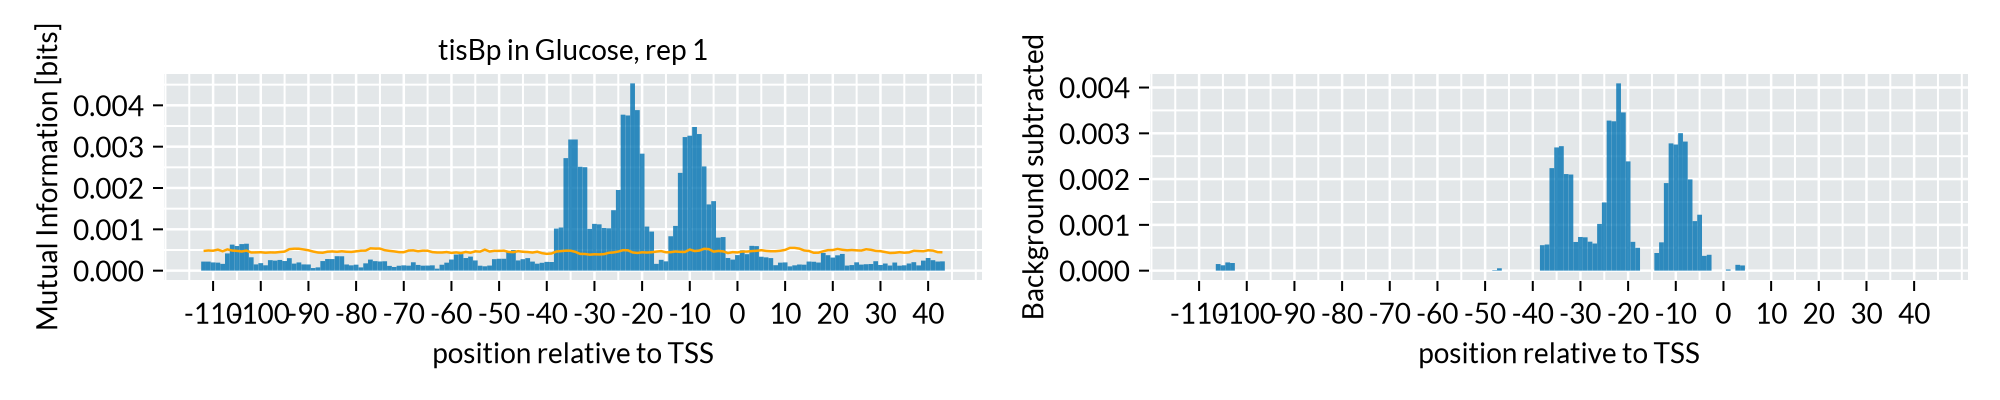

In [37]:
prom = "tisBp"
gc = 1
rep = 1
plot_with_background(prom, gc, rep)

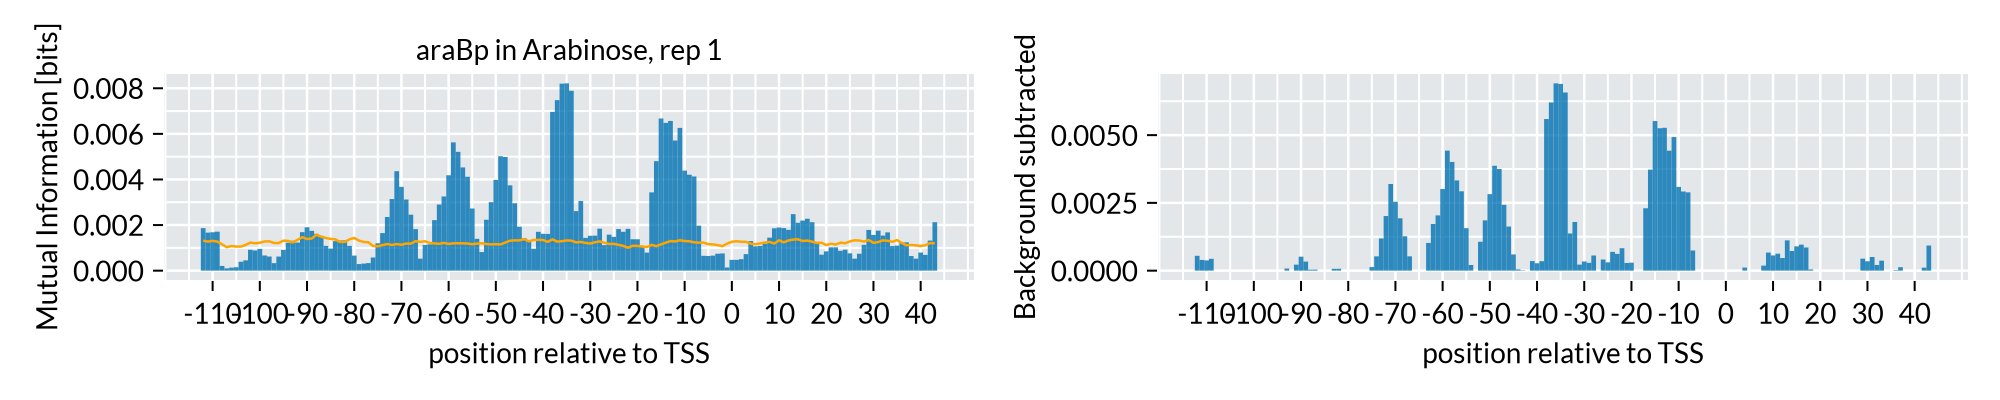

In [38]:
prom = "araBp"
gc = 3
rep = 1
plot_with_background(prom, gc, rep)

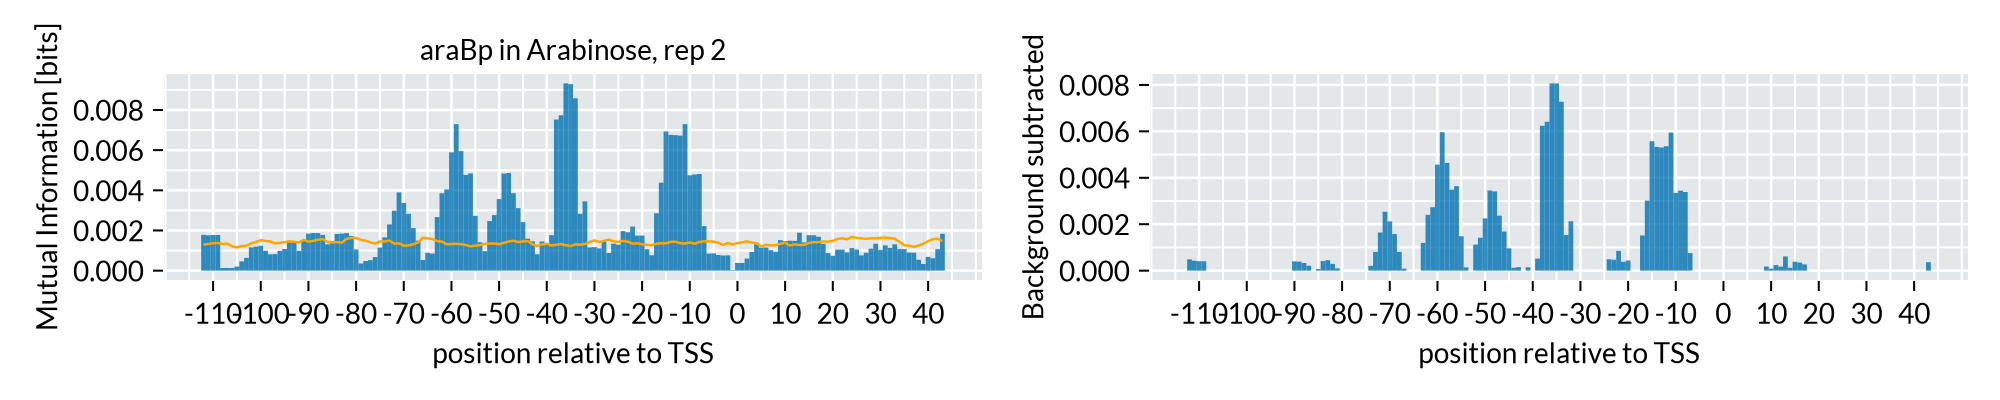

In [39]:
prom = "araBp"
gc = 3
rep = 2
plot_with_background(prom, gc, rep)

[0.0009001203670273782, 0.0008979156419696115, 0.0009245567764178869, 0.0009024222049558387, 0.0008407507912582324, 0.0009139696012864676, 0.0009664864886144988, 0.001017713606570243, 0.0010848636024847114, 0.0011059097642305076, 0.0011346054768496161, 0.001100320514246884, 0.0010477861693933784, 0.001018808166757978, 0.0010049980395598532, 0.0009266570351058517, 0.0009255833996220219, 0.0009625186966652469, 0.0008827731602806286, 0.000900838946917417, 0.0009294713611934953, 0.000908733553835763, 0.0009066955049362016, 0.0009634336004362726, 0.000987344596794154, 0.0009725503393972306, 0.001030865761606299, 0.0009589585275119952, 0.0009361428261558654, 0.000896017461965819, 0.0008783216494422626, 0.0008258304574537548, 0.0008430423674107701, 0.0008897107163436064, 0.0009050381385234925, 0.0009224251550797597, 0.0009619345431199657, 0.0009660100097218562, 0.0009556488104292802, 0.0010243230562583436, 0.0010116866226399228, 0.0010036479607935204, 0.0010262047213188232, 0.0010600262407668

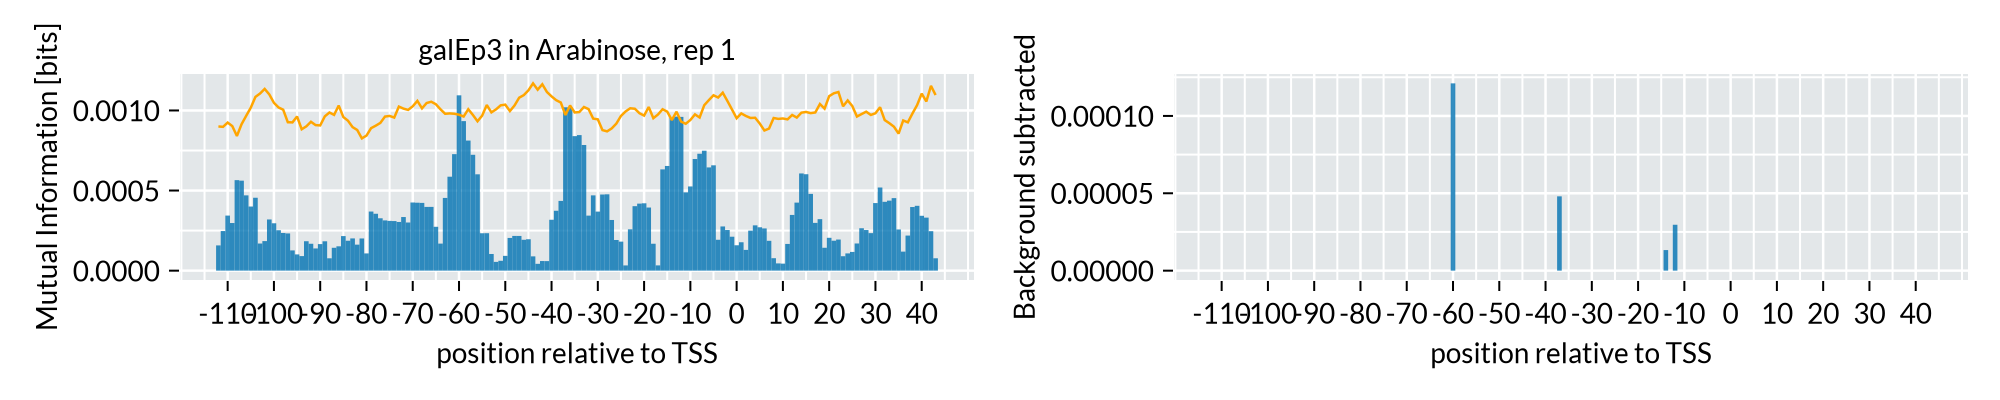

In [34]:
prom = "galEp3"
gc = 3
rep = 1
plot_with_background(prom, gc, rep)

[0.0035026686688237616, 0.003325143592395733, 0.0035287935335143856, 0.0036724517781488706, 0.003647615028554885, 0.003495576046670981, 0.0035218356337647903, 0.003096600911851464, 0.0030640441637644423, 0.0030678055018764504, 0.0031349719811237437, 0.003062684529785817, 0.0031040933270127615, 0.003084444317279704, 0.003447574671830392, 0.0033136144277939837, 0.0033668631221574095, 0.003315038020461173, 0.0031011812146687417, 0.0029232546453634755, 0.003338098553096286, 0.003297295938927098, 0.0033244984526010638, 0.003455019177607551, 0.003296610394186249, 0.0029107523847747736, 0.002775318175169852, 0.0029583247024258987, 0.002816827637132579, 0.0032627357897796207, 0.00321875520036616, 0.0034764300048351973, 0.0036679186391241902, 0.003841265201368437, 0.003301363710930388, 0.0034067661092216277, 0.0033857596083960275, 0.0030590122653425074, 0.0030884416821454572, 0.0031739290270422172, 0.0033342284725685705, 0.003461416403615223, 0.003560714723240025, 0.0033618332188505165, 0.00351

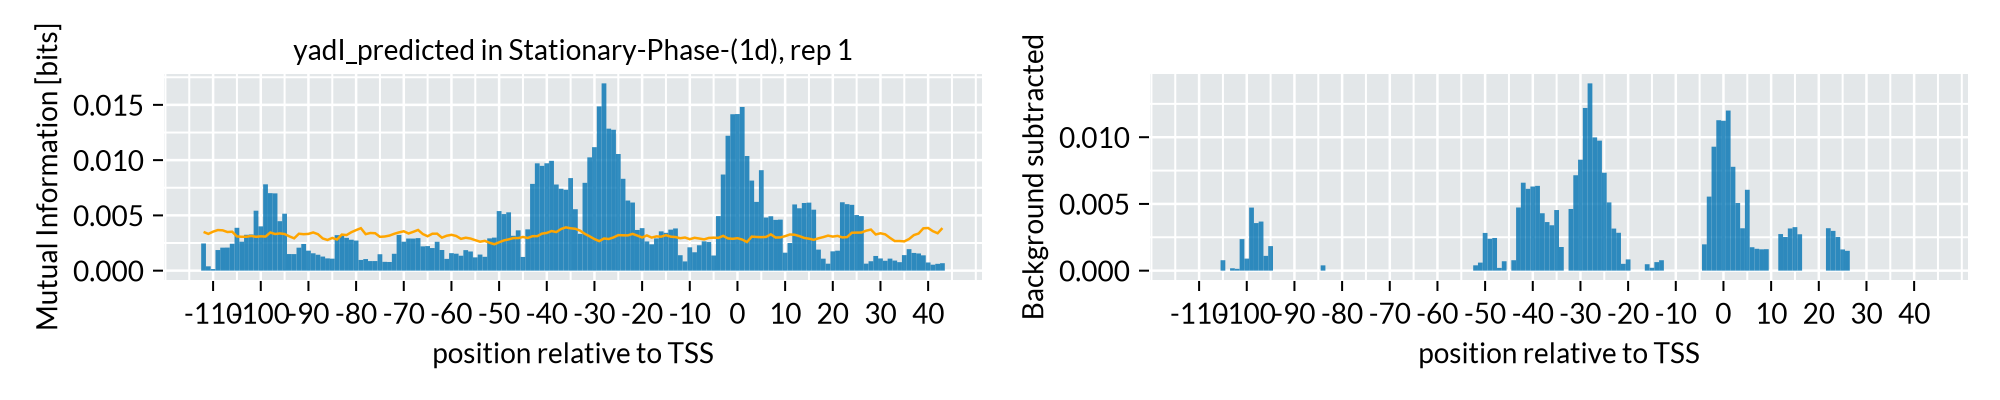

In [35]:
prom = "yadI_predicted"
gc = 7
rep = 1
plot_with_background(prom, gc, rep)

In [96]:
for ind in df_gcs.Index
    println("doing condition $ind")
    gcs, reps = wgregseq.utils._get_reps(ind)
    l = length(gcs)
    for i in 1:l
        gc = gcs[i]
        rep = reps[i]
        
        df = wgregseq.utils.get_dataset(gc, df_map=df_map, no_match=true)
                
        # Convert column A to a dictionary mapping values to indices
        indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))
        
        # Efficiently find indices for each value in `values_to_search`
        result = [get(indices_map, value, 0) for value in df.barcode]
        
        df.barcode_ind = result
        df = df[df.barcode_ind .> 0, :]
        insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])
        
        for gdf in groupby(df, :name)
            name = gdf.name[1]
            CSV.write("counts_per_gene/$gc-$name.csv", gdf)
        end
    end
end

doing condition 1
doing condition 2
doing condition 3
doing condition 4
doing condition 5
doing condition 6
doing condition 7
doing condition 8
doing condition 9
doing condition 10
doing condition 11
doing condition 12
doing condition 13
doing condition 14
doing condition 15
doing condition 16
doing condition 17
doing condition 18
doing condition 19
doing condition 20
doing condition 21
doing condition 22
doing condition 23
doing condition 24
doing condition 25
doing condition 28
doing condition 29
doing condition 30
doing condition 31
doing condition 32
doing condition 33
doing condition 34
doing condition 35
doing condition 36
doing condition 37
doing condition 38
doing condition 39
doing condition 40
doing condition 41


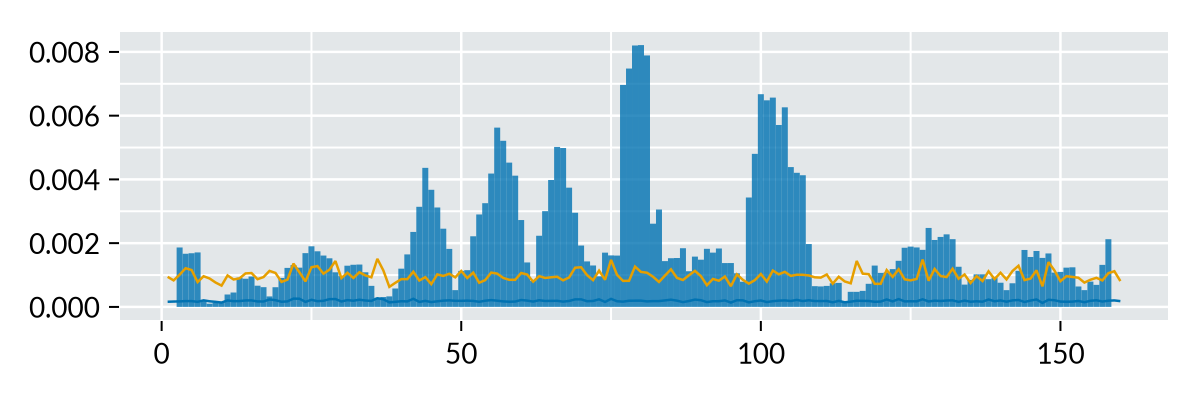

In [44]:
prom = "araBp"
gc = "3"
rep = "1"


_df = df_shuffle[(df_shuffle.promoter .== prom) .& (df_shuffle.gc .== gc) .& (df_shuffle.rep .== rep), :]

fig = Figure(size=(600, 200))
ax = Axis(fig[1, 1])

d = 2


df = wgregseq.utils.get_dataset("$gc-$rep", df_map=df_map, no_match=true)
    
# Convert column A to a dictionary mapping values to indices
indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))

# Efficiently find indices for each value in `values_to_search`
result = [get(indices_map, value, 0) for value in df.barcode]

df.barcode_ind = result
df = df[df.barcode_ind .> 0, :]
insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])


gdf = df[df.name .== prom, :]
x = wgregseq.footprints.mutual_information_mutation_vec(
    int_promoter=df_map[gdf.barcode_ind, :int_promoter], 
    int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
    ct=gdf.ct, 
    ct_0=gdf.ct_0, 
    ct_1=gdf.ct_1,
)


barplot!(1+d:160-d, [mean(x[i-d:i+d]) for i in 1+d:160-d], gap=0)

lines!(ax, 1:160, _df.mu[1])
lines!(ax, 1:160, _df.mu[1] .+ (3 .* _df.sigma[1]))

fig

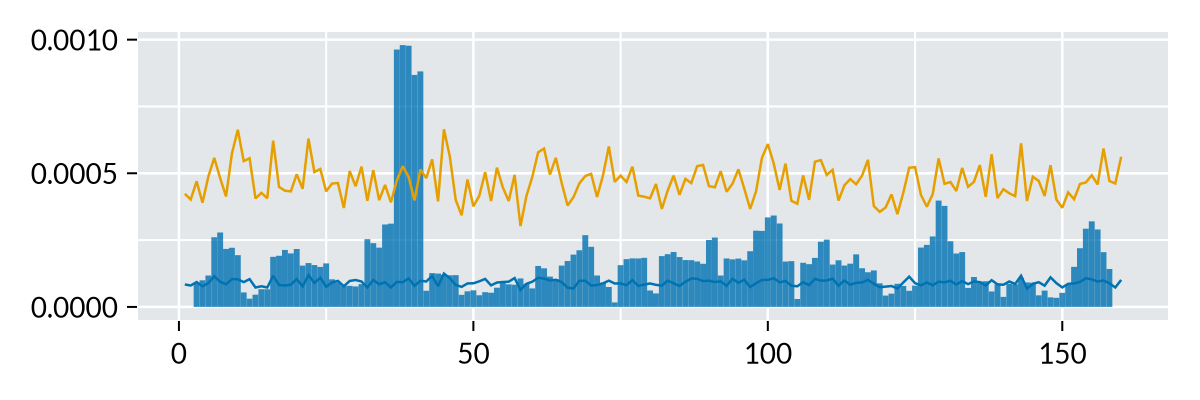

In [45]:
prom = "araBp"
gc = "1"
rep = "1"


_df = df_shuffle[(df_shuffle.promoter .== prom) .& (df_shuffle.gc .== gc) .& (df_shuffle.rep .== rep), :]

fig = Figure(size=(600, 200))
ax = Axis(fig[1, 1])

d = 2


df = wgregseq.utils.get_dataset("$gc-$rep", df_map=df_map, no_match=true)
    
# Convert column A to a dictionary mapping values to indices
indices_map = Dict(value => i for (i, value) in enumerate(df_map.barcode))

# Efficiently find indices for each value in `values_to_search`
result = [get(indices_map, value, 0) for value in df.barcode]

df.barcode_ind = result
df = df[df.barcode_ind .> 0, :]
insertcols!(df, 1, :name => df_map[df.barcode_ind, :name])


gdf = df[df.name .== prom, :]
x = wgregseq.footprints.mutual_information_mutation_vec(
    int_promoter=df_map[gdf.barcode_ind, :int_promoter], 
    int_wt=df_wt[df_wt.promoter .== prom, "int_wt"], 
    ct=gdf.ct, 
    ct_0=gdf.ct_0, 
    ct_1=gdf.ct_1,
)


barplot!(1+d:160-d, [mean(x[i-d:i+d]) for i in 1+d:160-d], gap=0)

lines!(ax, 1:160, _df.mu[1])
lines!(ax, 1:160, _df.mu[1] .+ (3 .* _df.sigma[1]))

fig